In [1]:
def fourier_transform_2(g):
    from pyzx.utils import EdgeType, VertexType
    del_e = []
    del_v = []
    add_e = []
    types = g.types()
    phases = g.phases()
    es = list(g.edges())
    vs = list(g.vertices())

    for v in vs:
        arity = len(g.neighbors(v))
        if types[v] == VertexType.H_BOX and arity == 2 and phases[v] != 1:
            phase = phases[v]
            v1,v2 = g.neighbors(v)
            c = g.add_vertex(VertexType.Z)
            vh1 = g.add_vertex(VertexType.H_BOX)
            vh2 = g.add_vertex(VertexType.H_BOX)
            ch1 = g.add_vertex(VertexType.H_BOX)
            c2 = g.add_vertex(VertexType.Z)
            ch2 = g.add_vertex(VertexType.H_BOX)
            add_e.append(g.edge(v1, vh1))
            add_e.append(g.edge(v2, vh2))
            add_e.append(g.edge(vh1, c))
            add_e.append(g.edge(vh2, c))
            add_e.append(g.edge(c, ch1))
            add_e.append(g.edge(ch1, c2))
            add_e.append(g.edge(c2, ch2))
            g.set_phase(ch2, phase*(-1/2))
            g.set_phase(v1, phases[v1]+phase*1/2)
            g.set_phase(v2, phases[v2]+phase*1/2)
            g.scalar.add_power(-2)
            # g.scalar.add_float(1/2)
            del_v.append(v)
            del_e.append(g.edge(v,v1))
            del_e.append(g.edge(v,v2))


    g.add_edges(add_e)
    g.remove_edges(del_e)
    for v in del_v:
        g.remove_vertex(v)

def fourier_transform_3(g):
    from pyzx.utils import EdgeType, VertexType
    del_e = []
    del_v = []
    add_e = []
    types = g.types()
    phases = g.phases()
    es = list(g.edges())
    vs = list(g.vertices())

    for v in vs:
        arity = len(g.neighbors(v))
        if types[v] == VertexType.H_BOX and arity == 3:
            phase = phases[v]
            v1,v2,v3 = g.neighbors(v)
            c = g.add_vertex(VertexType.Z)
            vh1 = g.add_vertex(VertexType.H_BOX)
            vh2 = g.add_vertex(VertexType.H_BOX)
            vh3 = g.add_vertex(VertexType.H_BOX)
            ch1 = g.add_vertex(VertexType.H_BOX)
            c2 = g.add_vertex(VertexType.Z)
            ch2 = g.add_vertex(VertexType.H_BOX)
            add_e.append(g.edge(v1, vh1))
            add_e.append(g.edge(v2, vh2))
            add_e.append(g.edge(v3, vh3))
            add_e.append(g.edge(vh1, c))
            add_e.append(g.edge(vh2, c))
            add_e.append(g.edge(vh3, c))
            add_e.append(g.edge(c, ch1))
            add_e.append(g.edge(ch1, c2))
            add_e.append(g.edge(c2, ch2))
            vh12 = g.add_vertex(VertexType.H_BOX)
            vh23 = g.add_vertex(VertexType.H_BOX)
            vh31 = g.add_vertex(VertexType.H_BOX)
            add_e.append(g.edge(v1, vh12))
            add_e.append(g.edge(vh12, v2))
            add_e.append(g.edge(v2, vh23))
            add_e.append(g.edge(vh23, v3))
            add_e.append(g.edge(v3, vh31))
            add_e.append(g.edge(vh31, v1))
            g.set_phase(ch2, phase*(1/4) )
            g.set_phase(vh12, phase*(1/2))
            g.set_phase(vh23, phase*(1/2) )
            g.set_phase(vh31, phase*(1/2) )
            g.set_phase(v1, phases[v1]-phase*1/4)
            g.set_phase(v2, phases[v2]-phase*1/4)
            g.set_phase(v3, phases[v3]-phase*1/4)
            g.scalar.add_power(-2)
            # g.scalar.add_float(1/2)
            del_v.append(v)
            del_e.append(g.edge(v,v1))
            del_e.append(g.edge(v,v2))
            del_e.append(g.edge(v,v3))


    g.add_edges(add_e)
    g.remove_edges(del_e)
    for v in del_v:
        g.remove_vertex(v)

def val(g1):
    return abs(zx.to_quimb_tensor(g1).contract(output_inds={}))

# Benchmark: `Quimb` vs `Quimb+ZX` on `Sycamore` circuits

In [2]:
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import quimb.tensor as qtn
import cotengra as ctg
import quimb as qu
import numpy as np
import pyzx as zx
import time, random
from typing import List
class CircuitGenerator:
    def __init__(self, depth):
        self.__depth = depth
        self.__file = f'circuits/depth_{self.__depth}.qsim'
    def zx(self):
        circ = zx.Circuit.from_qsim_file(self.__file)
        g = circ.to_graph(zh=True)
        num_qubits = circ.qubits
        g.apply_state("0"*num_qubits)
        g.apply_effect("0"*num_qubits)
        zx.to_gh(g)
        return g
    def qtn(self):
        circ = qtn.Circuit.from_qasm_file(self.__file, gate_opts={})
        psi_f = qtn.MPS_computational_state('0' * (circ.N))
        tn = circ.psi & psi_f
        return tn

In [22]:
class FsimBenchmark():
    def __init__(self, n:int, depths: List[int], strategies: List[str]):
        self.__n = n
        self.__depths = depths
        self.__strategies = strategies
        self.cost = 'estimate'
    def __simplify_quimb(self, tensor):
        while True:
            try:
                tensor.full_simplify_('ACDRSL',output_inds=())
                break
            except Exception as e:
                print(e)
                continue
        return tensor
    
    def __contract_quimb(self, tensor):
        tensor = tensor.contract(output_inds = (),backend='jax')
        return tensor

    def __estimate_quimb(self, tensor):
        print(f'#Tensors={tensor.num_tensors}, #Indices={tensor.num_indices}')
        if tensor.num_tensors > 1:
            ctg.hyper._HYPER_SEARCH_SPACE['kahypar']['imbalance']['max'] = 0.4
            opt = ctg.HyperOptimizer(
                methods=['kahypar'],
                max_repeats=64,
                progbar=False,
                minimize='flops'
            )
            info = tensor.contract(all, optimize=opt,output_inds=(), get='path-info')
            tree = opt.get_tree()
            print(f' Contraction cost = {tree.contraction_cost():e} \n Memory cost = {tree.contraction_width():e}')
            return tree.contraction_cost(), tree.contraction_width()
        else:
            print("Tensor is a single scalar")
            return 26,1
    
    def __run_tensor(self, tn):
        if self.__cost == 'actual':
            t = time.time()
            tn = self.__contract_quimb(self.__simplify_quimb(tn))
            tn_time = time.time() - t
        else:
            tn_time, tn_mem = self.__estimate_quimb(self.__simplify_quimb(tn))
        return tn_time
    
    def __run_quimb_tensor(self):
        tn = self.__generator.qtn()
        quimb_time = self.__run_tensor(tn) 
        return quimb_time

    def __run_zx_tensor(self, strategy):
        g = self.__generator.zx()
        g = optimize_graph(g, strategy)
        tn = zx.to_quimb_tensor(g)
        zx_time = self.__run_tensor(tn)
        return zx_time


    def __run_tensors(self):
        quimb_times = []
        zx_times = {strategy:[] for strategy in self.__strategies}
        for _ in range(self.__n):
            quimb_times.append(self.__run_quimb_tensor())
            for strategy in self.__strategies:
                zx_times[strategy].append(self.__run_zx_tensor(strategy))
        quimb_times = np.mean(quimb_times)
        for strategy in self.__strategies:
            zx_times[strategy] = np.mean(zx_times[strategy])
        return quimb_times, zx_times

    def __run_with_depths(self):
        quimb_times = []
        zx_times = {strategy:[] for strategy in self.__strategies}
        for depth in self.__depths:
            self.__generator = CircuitGenerator(depth)
            quimb, zx = self.__run_tensors()
            quimb_times.append(quimb)
            for strategy in self.__strategies:
                zx_times[strategy].append(zx[strategy])
        return quimb_times, zx_times

    def display_plot(self,zx_times, quimb_times, range):
        fig, ax = plt.subplots()
        ax.plot(range, quimb_times, label = "quimb")
        for strategy in self.__strategies:
            ax.plot(range, zx_times[strategy], label = strategy)
        ax.set_xlabel("depths")
        ax.set_ylabel("time (s)")
        ax.set_yscale('log')
        ax.legend()

    def test(self, cost: str= 'estimate'):
        self.__cost = cost
        quimb_times, zx_times =  self.__run_with_depths()
        self.display_plot( zx_times, quimb_times, self.__depths)
    
        

In [23]:
def optimize_graph(g, strategy):
        assert strategy in ['strat_1', 'strat_2', 'strat_3', 'strat_4'], 'Please select a valid strategy'
        if strategy == 'strat_1':
            zx.full_reduce(g)
        elif strategy == 'strat_2':
            zx.full_reduce(g)
            zx.hsimplify.new_simp(g,quiet=True)
        elif strategy == 'strat_3':
            zx.full_reduce(g)
            zx.hsimplify.new_simp(g,quiet=True)
            fourier_transform_3(g)
            zx.hsimplify.par_hbox_simp(g,quiet=True)
            fourier_transform_2(g)
        elif strategy == 'strat_4':
            zx.simplify.greedy_simp(g, boundaries=True, gadgets=True, max_v=g.num_vertices(), cap=-1, quiet=True)
            zx.hsimplify.new_simp(g,quiet=True)
            fourier_transform_3(g)
            zx.hsimplify.par_hbox_simp(g,quiet=True)
            fourier_transform_2(g)
            zx.hsimplify.par_hbox_simp(g,quiet=True)
        return g

In [24]:
depths = [ 3,4,5,6,7,8]
strategies = ['strat_1', 'strat_2', 'strat_3']
cb = FsimBenchmark(1, depths, strategies)
cb.test(cost='estimate')

#Tensors=12, #Indices=21
 Contraction cost = 7.120000e+02 
 Memory cost = 5.000000e+00
#Tensors=77, #Indices=53
 Contraction cost = 1.904000e+03 
 Memory cost = 5.000000e+00
#Tensors=83, #Indices=52
 Contraction cost = 1.864000e+03 
 Memory cost = 5.000000e+00
#Tensors=43, #Indices=39
 Contraction cost = 1.318000e+03 
 Memory cost = 5.000000e+00
#Tensors=40, #Indices=73
 Contraction cost = 4.769600e+04 
 Memory cost = 1.000000e+01
#Tensors=178, #Indices=127
 Contraction cost = 5.398800e+04 
 Memory cost = 1.000000e+01
#Tensors=180, #Indices=117
 Contraction cost = 5.898000e+04 
 Memory cost = 1.000000e+01
#Tensors=153, #Indices=123
 Contraction cost = 5.771600e+04 
 Memory cost = 1.000000e+01
#Tensors=51, #Indices=96
 Contraction cost = 2.330320e+05 
 Memory cost = 1.200000e+01
#Tensors=309, #Indices=201
 Contraction cost = 3.677240e+05 
 Memory cost = 1.200000e+01
#Tensors=303, #Indices=186
 Contraction cost = 6.046320e+05 
 Memory cost = 1.400000e+01
#Tensors=255, #Indices=188
 Contr

In [3]:
class CircuitBenchmark():
    def __init__(self, n: int, depths: List[int]):
        self.__n = n
        self.__depths = depths
        self.__cost = 'estimate'
    def run_with_depths(self):
        zx_times, quimb_times = [], []
        for depth in self.__depths:
            self.__depth = depth
            self.__generator = CircuitGenerator( depth=self.__depth )
            zx_time, quimb_time = self.__run_tensors()
            zx_times.append(zx_time)
            quimb_times.append(quimb_time)
        return zx_times, quimb_times
    
    def __simplify_quimb(self, tensor):
        while True:
            try:
                tensor.full_simplify_('ARSL',output_inds=())
                break
            except Exception as e:
                print(e)
                continue
        return tensor
    
    def __contract_quimb(self, tensor):
        tensor = tensor.contract(output_inds = (),backend='jax')
        return tensor

    def __estimate_quimb(self, tensor):
        print(f'#Tensors={tensor.num_tensors}, #Indices={tensor.num_indices}')
        if tensor.num_tensors > 1:
            ctg.hyper._HYPER_SEARCH_SPACE['kahypar']['imbalance']['max'] = 0.1
            opt = ctg.HyperOptimizer(
                methods=['kahypar'],
                max_repeats=128,
                progbar=True,
                minimize='flops'
            )
            info = tensor.contract(all, optimize=opt,output_inds=(), get='path-info')
            tree = opt.get_tree()
            print(f' Contraction cost = {tree.contraction_cost():e} \n Memory cost = {tree.contraction_width():e}')
            return tree.contraction_cost(), tree.contraction_width()
        else:
            print("Tensor is a single scalar")
            return 26,1

    def __optimize_graph(self, g):
        zx.full_reduce(g)
        # zx.simplify.simulated_annealing_simp(g, cap=-20, iterations=100, quiet=True)
        zx.hsimplify.new_simp(g,quiet=True)
        fourier_transform_3(g)
        zx.hsimplify.par_hbox_simp(g,quiet=True)
        fourier_transform_2(g)
        
        return g

    def __run_tensor(self):
        tn1 = self.__generator.qtn()
        g = self.__generator.zx()
        

        if self.__cost == 'actual':
            t = time.time()
            quimb_tn = self.__contract_quimb(self.__simplify_quimb(tn1))
            quimb_time = time.time() - t

            g = self.__optimize_graph(g)
            tn2 = zx.to_quimb_tensor(g)
            t = time.time()
            zx_tensor = self.__contract_quimb(self.__simplify_quimb(tn2))
            zx_time = time.time() - t
        else:
            quimb_time, quimb_mem = self.__estimate_quimb(self.__simplify_quimb(tn1))

            g = self.__optimize_graph(g)
            tn2 = zx.to_quimb_tensor(g)
            zx_time, zx_mem = self.__estimate_quimb(self.__simplify_quimb(tn2))

        if self.__cost == 'actual' and abs(abs(quimb_tn)-abs(zx_tensor))/abs(zx_tensor) > 1e-3:
            self.__run_tensor()
        else: 
            self.__zx_times.append(zx_time)
            self.__quimb_times.append(quimb_time)
    
    def __run_tensors(self):
        self.__zx_times = []
        self.__quimb_times = []
        for _ in range(self.__n):
            self.__run_tensor()
        return (np.mean(self.__zx_times), np.mean(self.__quimb_times))

    def display_plot(self,zx_times, quimb_times, range):
        fig, ax = plt.subplots()
        ax.plot(range, zx_times, label = "quimb+ZX")
        ax.plot(range, quimb_times, label = "quimb")
        ax.set_xlabel("depths")
        ax.set_ylabel("time (s)")
        # ax.set_title(
        #     " Sycamore circuits from {} to {} {}, fixed {} of {}".format(
        #          range[0], range[-1], var_type, fixed_type, fixed_quant
        #     )
        # )
        ax.legend()

    def test(self, cost: str= 'estimate'):
        self.__cost = cost
        zx_times, quimb_times =  self.run_with_depths()

        self.display_plot( zx_times, quimb_times, self.__depths)
        improvement = [i/j for i, j in zip(quimb_times, zx_times)]
        print(f'Improvement : {improvement}')
        print(f'Average improvement: {np.mean(improvement)}')

#Tensors=12, #Indices=21


log2[SIZE]: 1.00 log10[FLOPs]: 1.72: 100%|██████████| 128/128 [00:25<00:00,  4.96it/s]


 Contraction cost = 2.600000e+01 
 Memory cost = 1.000000e+00
#Tensors=1, #Indices=0
Tensor is a single scalar
#Tensors=51, #Indices=96


log2[SIZE]: 12.00 log10[FLOPs]: 5.66: 100%|██████████| 128/128 [00:30<00:00,  4.25it/s]


 Contraction cost = 2.260880e+05 
 Memory cost = 1.200000e+01
#Tensors=318, #Indices=233


log2[SIZE]: 12.00 log10[FLOPs]: 5.85: 100%|██████████| 128/128 [00:29<00:00,  4.32it/s]


 Contraction cost = 3.575600e+05 
 Memory cost = 1.200000e+01
#Tensors=161, #Indices=313


log2[SIZE]: 28.00 log10[FLOPs]: 10.66: 100%|██████████| 128/128 [00:44<00:00,  2.90it/s]


 Contraction cost = 2.302635e+10 
 Memory cost = 2.800000e+01
#Tensors=874, #Indices=595


log2[SIZE]: 26.00 log10[FLOPs]: 11.22: 100%|██████████| 128/128 [03:56<00:00,  1.84s/it]


 Contraction cost = 8.314104e+10 
 Memory cost = 2.600000e+01


NameError: name 'circuit_type' is not defined

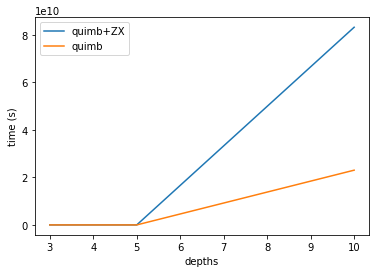

: 

In [4]:
depths = [3, 5, 10]
cb = CircuitBenchmark(1, depths)
cb.test(cost='estimate')